# TP Decision Tree & Random Forest

## Imports

In [19]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn import neighbors, datasets
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import math
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap
from sklearn import clone
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn import clone


## Dataset

- Load iris dataset
- Split in train/test

In [2]:
iris = datasets.load_iris()
X_all = iris.data
y_all = iris.target

# Verify datas structures
print(X_all.shape) # (150, 4)
print(y_all.shape) # (150,)
print(np.unique(y_all)) # [0 1 2]

# Split datas in 2 parts (80% for trainning/validation and 20% for test)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, shuffle=True, stratify=y_all)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(150, 4)
(150,)
[0 1 2]
(120, 4)
(120,)
(30, 4)
(30,)


## Decision Tree Classifier
Create the [decision tree classifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier), train it, predict the results of the test set and score them.

Use the entropy criterion, as seen during the course. This is useful to maximize the information gain. You can specify other parameters such as the depth of the tree and others (read the doc).


In [3]:
clf_t = DecisionTreeClassifier(random_state=0)

#cross_val_score(clf, X_train, y_train, cv=4)

The function below will print what the tree computes when you give it a sample. Use it to understand what your tree really do.

In [4]:
def tree_to_code(this_tree, feature_names):
    from sklearn.tree import _tree
    tree = this_tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree.value[node]))

    recurse(0, 1)

In [5]:
clf_t.fit(X_train, y_train, sample_weight=None, check_input=True, X_idx_sorted=None)
tree_to_code(clf_t, [iris.feature_names[0],iris.feature_names[1],iris.feature_names[2],iris.feature_names[3]])

def tree(sepal length (cm), sepal width (cm), petal length (cm), petal width (cm)):
  if petal width (cm) <= 0.800000011920929:
    return [[ 40.   0.   0.]]
  else:  # if petal width (cm) > 0.800000011920929
    if petal width (cm) <= 1.6500000953674316:
      if petal length (cm) <= 4.949999809265137:
        return [[  0.  38.   0.]]
      else:  # if petal length (cm) > 4.949999809265137
        if sepal length (cm) <= 6.150000095367432:
          if petal width (cm) <= 1.5499999523162842:
            return [[ 0.  0.  1.]]
          else:  # if petal width (cm) > 1.5499999523162842
            return [[ 0.  1.  0.]]
        else:  # if sepal length (cm) > 6.150000095367432
          return [[ 0.  0.  2.]]
    else:  # if petal width (cm) > 1.6500000953674316
      if petal length (cm) <= 4.850000381469727:
        if sepal width (cm) <= 3.0:
          return [[ 0.  0.  2.]]
        else:  # if sepal width (cm) > 3.0
          return [[ 0.  1.  0.]]
      else:  # if petal length (

If you want to understand the decision tree structure, you can read [this](http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html).

The classifier contains an attribute *tree_* that stores the entire tree built. The classifier gives some methods to exploit it. Call ".decision_path()" on the classifier with the test set as parameter. You'll have the paths for all the test samples.

*NB: to transform a csr_matrix to an array, just call ".toarray()".*

How many samples are contained in the test set ?

In [6]:
paths = clf_t.decision_path(X_train).toarray()
len(paths)

120

How many nodes are there in the tree ?

In [7]:
clf_t.tree_.node_count

15

How many samples go through each node ?

In [8]:
node = 0;
for s in zip(*paths):
    print("Node %d has %d samples gone trough" % (node, np.sum(s)))
    node += 1

Node 0 has 120 samples gone trough
Node 1 has 40 samples gone trough
Node 2 has 80 samples gone trough
Node 3 has 42 samples gone trough
Node 4 has 38 samples gone trough
Node 5 has 4 samples gone trough
Node 6 has 2 samples gone trough
Node 7 has 1 samples gone trough
Node 8 has 1 samples gone trough
Node 9 has 2 samples gone trough
Node 10 has 38 samples gone trough
Node 11 has 3 samples gone trough
Node 12 has 2 samples gone trough
Node 13 has 1 samples gone trough
Node 14 has 35 samples gone trough


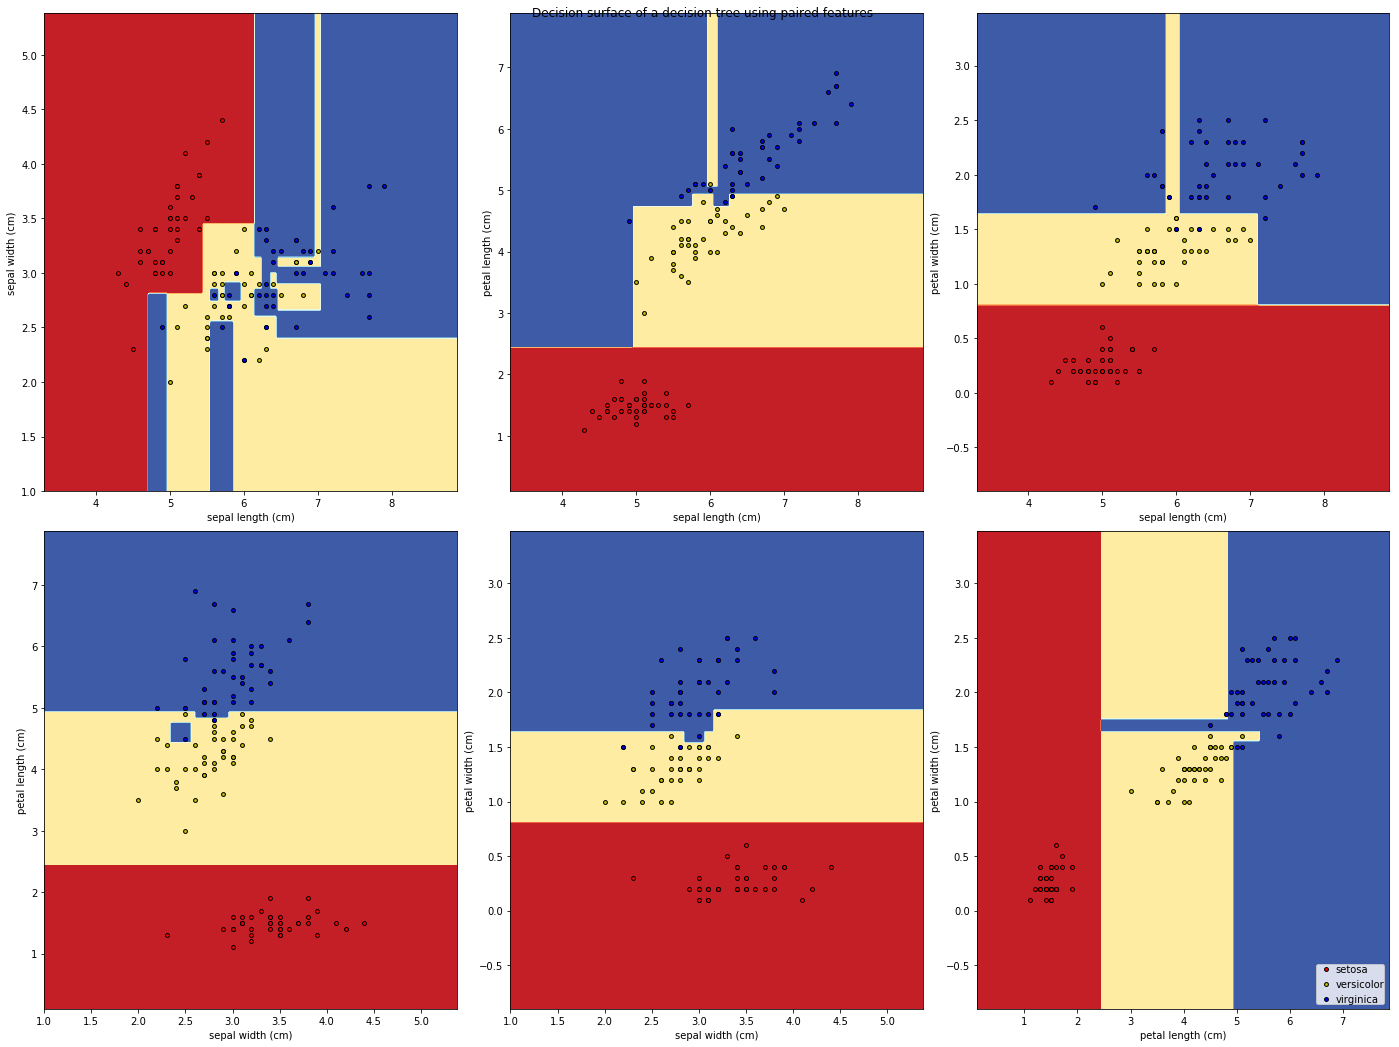

In [9]:
# Plot the decision surface of a decision tree for each 2 features combination
# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

plt.figure(figsize=(20,15))

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = X_train[:, pair]
    y = y_train

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)


plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()

### More resources

- [Decision Trees](http://scikit-learn.org/stable/modules/tree.html)
- [Plot the decision surface of a decision tree on the iris dataset](http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html#sphx-glr-auto-examples-tree-plot-iris-py)

--------------

## Random Forest classifier
Now create a random forest classifier and compare it with the decision tree.

In [15]:
clf_rf = RandomForestClassifier(max_depth=10, random_state=0)
print(clf_rf.fit(X_train, y_train))
print(clf_rf.feature_importances_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
[ 0.16404491  0.00362612  0.3580104   0.47431857]


Explain the parameters you chose to use. (answer with text in the following cell)

    n_estimators : integer, optional (default=10) The number of trees in the forest.
    criterion : string, optional (default=”gini”) The function to measure the quality of a split. 
                                                  Supported criteria are “gini” for the Gini impurity and 
                                                  “entropy” for the information gain. Note: this parameter 
                                                  is tree-specific.
    max_features : int, float, string or None, optional (default=”auto”)  The number of features to consider when
                                                                          looking for the best split
    max_depth : integer or None, optional (default=None)  The maximum depth of the tree. If None, then nodes are
                                                          expanded until all leaves are pure or until all leaves
                                                          contain less than min_samples_split samples.
    

What is the difference between the "RandomForestClassifier" and the "RandomForestRegressor" ?
(answer with text in the following cell)

RandomForestClassifier: Fournit une prediction de classe (ex: classe de prix A, ou classe de prix B).

RandomForestRegressor:  Fournit en réponse une valeur continue (ex: 45.50,  65.20 etc...)

### More resources

- [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

-------------------
## Decision Tree VS Random Forest

To compare the two algorithms, we will train multiple times the two classifiers with only two features each time. This will permit us to plot it more easily and so what is going on.

You can find more info on what to do [here](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html). Compare only the two algorithmes seen here above. You can reuse a lot of code from this page.

Here is what you should get :

![comparison plots](http://asylamba.com/public/media/files/sources/randomforest-comp.png)

DecisionTree with features [0, 1] has a score of 0.95
RandomForest with 30 estimators with features [0, 1] has a score of 0.95
DecisionTree with features [0, 2] has a score of 0.991666666667
RandomForest with 30 estimators with features [0, 2] has a score of 0.991666666667
DecisionTree with features [0, 3] has a score of 0.975
RandomForest with 30 estimators with features [0, 3] has a score of 0.975
DecisionTree with features [1, 2] has a score of 0.983333333333
RandomForest with 30 estimators with features [1, 2] has a score of 0.983333333333
DecisionTree with features [1, 3] has a score of 0.975
RandomForest with 30 estimators with features [1, 3] has a score of 0.975
DecisionTree with features [2, 3] has a score of 0.991666666667
RandomForest with 30 estimators with features [2, 3] has a score of 0.991666666667


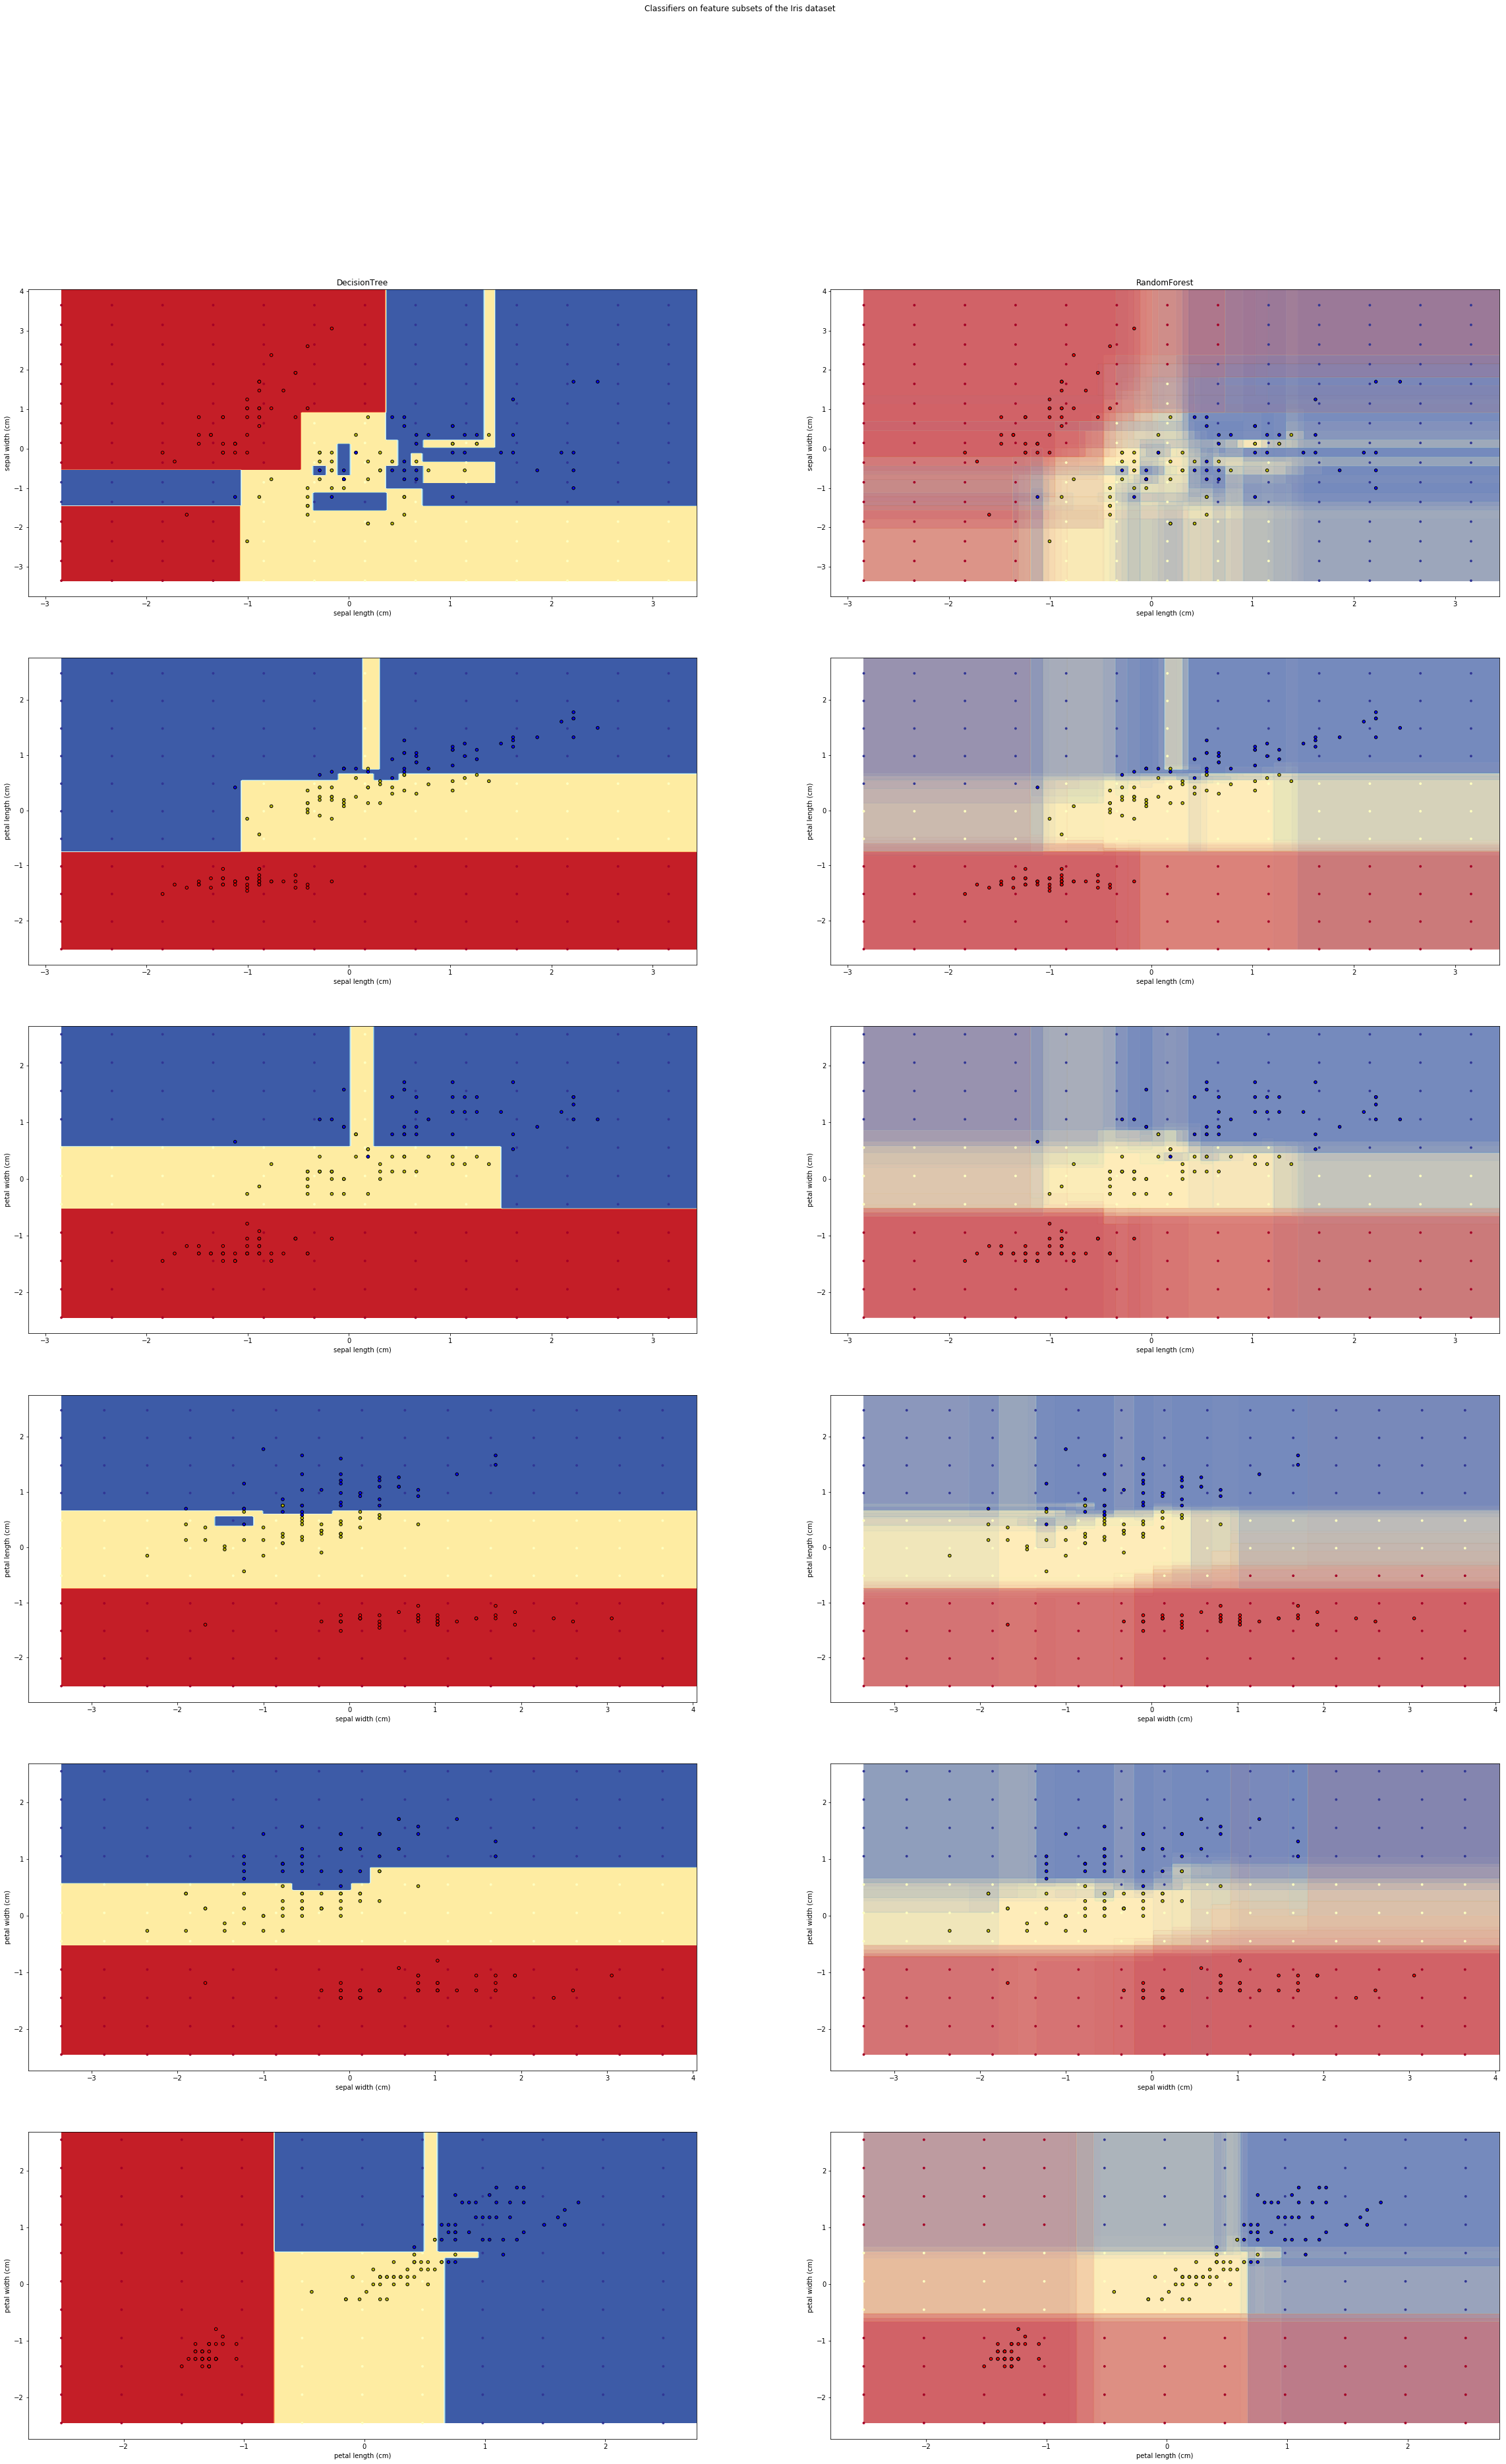

In [28]:
# Parameters
n_classes = 3
n_estimators = 30
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 0  # fix the seed on each iteration

plot_idx = 1
plt.figure(figsize=(40,60))
models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators)]

for pair in ([0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]):
    for model in models:
        # We only take the two corresponding features
        X = X_train[:, pair]
        y = y_train

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(
            ".")[-1][:-2][:-len("Classifier")]

        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(
                len(model.estimators_))
        print(model_details + " with features", pair,
              "has a score of", scores)

        plt.subplot(6, 2, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number
            # of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                         yy_coarser.ravel()]
                                         ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                                c=Z_points_coarser, cmap=cmap,
                                edgecolors="none")

        # specy labels names
        plt.xlabel(iris.feature_names[pair[0]])
        plt.ylabel(iris.feature_names[pair[1]])
        
        
        # Plot the training points, these are clustered together and have a
        # black outline
        plt.scatter(X[:, 0], X[:, 1], c=y,
                    cmap=ListedColormap(['r', 'y', 'b']),
                    edgecolor='k', s=20)
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset")
plt.axis("tight")

plt.show()


What can you say about these plots ? Why the plots from the Decision Tree contains plain red, blue and yellow when the ones from the Random Forest get shades of colors ? Explain.
(answer with text in the following cell)

Avec le Decision Tree nous n'avons que un seul arbre de decision et donc les zones de classification seront forcément nettement définie.

Avec le Random Forest nous avons plusieurs (autant que le nombre d'arbres dans la foret) zones de classification pour chaque classes.
La superposition de ces zones explique le "blur".

### Good work !
![forest](https://static.pexels.com/photos/26948/pexels-photo.jpg)